# Hyperspectral Images

### Load data

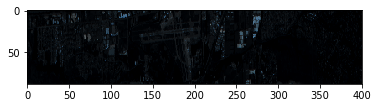

(88, 400, 3)

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy.io as sio
import os


hsimg_load = sio.loadmat('SanBarHyperIm.mat')
hsimg_data = hsimg_load['SanBarIm88x400']
# hsimg_load = sio.loadmat('PaviaHyperIm.mat')
# hsimg_data = hsimg_load['PaviaHyperIm']
himage_display = hsimg_data[:,:,0:3]
plt.imshow(himage_display)
plt.show()
hsimg_data[:,:,0:3].shape

### PCA - Number of Components Decision

We need about 3 components to retain 95% of the variance


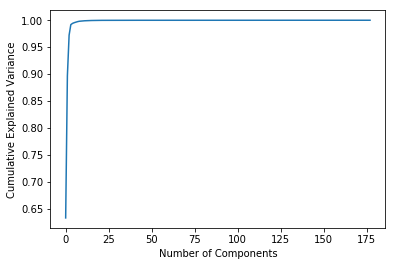

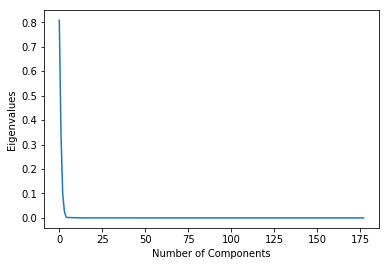

In [46]:
from sklearn.decomposition import PCA
data = hsimg_data.reshape(hsimg_data.shape[0] * hsimg_data.shape[1], hsimg_data.shape[2])
pca = PCA().fit(data)
cum_var = np.cumsum(pca.explained_variance_ratio_)
eigenvalues = pca.explained_variance_

count = 0
for var in cum_var:
    count += 1
    if var >= 0.95:
        n_components = count
        answer = "We need about "+ str(n_components) + " components to retain 95% of the variance"
        print(answer)
        break
        
plt.figure(1)
plt.plot(cum_var)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.figure(2)
plt.plot(eigenvalues)
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalues')
plt.show()

# Minumum Noise Factor --> Similar to PCA but removes noise from bands

### PCA - Actually run PCA

In [47]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from skimage.transform import rescale
from sklearn.cluster import KMeans
import numpy as np
import time

#Reshape to 2D - one column per component
data = hsimg_data.reshape(hsimg_data.shape[0] * hsimg_data.shape[1], hsimg_data.shape[2])

#Using PCA
pca = PCA(n_components=n_components)
reduced_data = pca.fit_transform(data)

#Since my data is not between [0,1], I rescale the data
min_max_scaler = MinMaxScaler()
reduced_data_scaled = min_max_scaler.fit_transform(reduced_data)

#Turn data back into 3 dimensions to control the downsampling of the data
reduced_data_3D = reduced_data_scaled .reshape(hsimg_data[:,:,0:3].shape)

#Flatten my data again for algorithm input
img_data = reduced_data_3D.reshape(reduced_data_3D.shape[0] * reduced_data_3D.shape[1], 3)

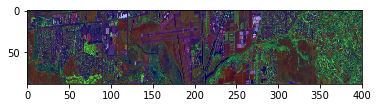

In [48]:
plt.imshow(reduced_data_3D)
plt.show()

### Do Kmeans

KMeans clustering time to do: 2.14s


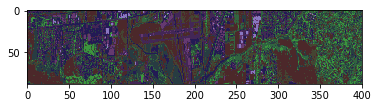

In [49]:
from sklearn.cluster import KMeans

n_clusters = 9

# Initializing KMeans
kmeans = KMeans(n_clusters=n_clusters)
# Fitting with inputs
t0 = time.time()

# Run algorithm
kmeans = kmeans.fit(img_data)
clusters = kmeans.cluster_centers_[kmeans.predict(img_data)]
t1 = time.time()

# Reshape the data into 3D
# img_clustered = clusters.reshape(img_r.shape)
img_clustered = clusters.reshape(reduced_data_3D.shape)

# Plot the data
plt.imshow(img_clustered)
title = 'KMeans clustering time to do: %.2fs' % (t1 - t0)
print(title)
plt.show()

### Mask the result - This is the general code that should go into the evaluation section, this repeats for each algorithm

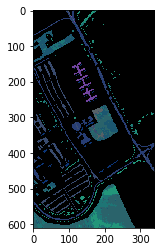

In [5]:
# Load mask data
htruth_load = sio.loadmat('PaviaGrTruthMask.mat')
htruth_mask = htruth_load['PaviaGrTruthMask']

# create mask with same dimensions as image
mask = np.zeros_like(img_clustered)

# copy your image_mask to all dimensions (i.e. colors) of your image
for i in range(3): 
    mask[:,:,i] = htruth_mask.copy()

# apply the mask to your image
masked_image = img_clustered*mask

plt.imshow(masked_image)
plt.show()

### Run martin index and load ground truth 

In [6]:
from collections import defaultdict

def martinIndex(groundTruth, segmentedImage):
	def imageToHashSegmented(arr):
		myHash = {}
		for i in range(len(arr)):
			for j in range(len(arr[0])):
				tempTuple = tuple(arr[i][j].tolist())
				if tempTuple in myHash:
					myHash[tempTuple].add((i,j))
				else:
					myHash[tempTuple] = {(i,j)}
		return myHash
	def imageToHash(arr):
		myHash = {}
		for i in range(len(arr)):
			for j in range(len(arr[0])):
				if arr[i][j] in myHash:
					myHash[arr[i][j]].add((i,j))
				else:
					myHash[arr[i][j]] = {(i,j)}
		return myHash

	def WJ(hashGround):
		totalPixels = len(groundTruth) * len(groundTruth[0])
		wjHash = defaultdict(int)
		for x in hashGround:
			wjHash[x] = len(hashGround[x])/totalPixels
		return wjHash

	def WJI(hashGround, hashSegmented):
		wjiHash = defaultdict(int)
		wjiHashDen = defaultdict(int)
		for j in hashGround:
			for i in hashSegmented:
				if len(hashGround[j].intersection(hashSegmented[i])) > 0:
					intersection = 1
				else:
					intersection = 0
				wjiHash[(j,i)] = len(hashSegmented[i]) * intersection
				wjiHashDen[j] += len(hashSegmented[i]) * intersection
		for j in hashGround:
			for i in hashSegmented:
				wjiHash[(j,i)] /= wjiHashDen[j]
		return wjiHash

	def EGS(hashGround, hashSegmented):
		martinIndex = 0
		wji = WJI(hashGround, hashSegmented)
		wj = WJ(hashGround)
		for j in hashGround:
			innerSum = 1
			for i in hashSegmented:
				innerSum -= (len(hashGround[j].intersection(hashSegmented[i])) / len(hashGround[j].union(hashSegmented[i]))) * wji[(j,i)]
			innerSum *= wj[j]
			martinIndex += innerSum
		return martinIndex
	if segmentedImage[0][0].size>1:
		return EGS(imageToHash(groundTruth), imageToHashSegmented(segmentedImage))        
	return EGS(imageToHash(groundTruth), imageToHash(segmentedImage))

In [7]:
hgtruth_load = sio.loadmat('PaviaGrTruth.mat')
hgtruth_mask = hgtruth_load['PaviaGrTruth']

martinIndex(hgtruth_mask, masked_image)*1000

163.08547183036097

### SOM

Self-Organizing Map clustering time to do: 4.22s


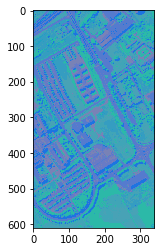

In [8]:
from minisom import MiniSom

n_clusters = 9

t0 = time.time()
#Run Algorithm
som = MiniSom(1, n_clusters, 3, sigma=0.1, learning_rate=0.2)  # 3x1 = 3 final colors
som.random_weights_init(img_data)
starting_weights = som.get_weights().copy()  # saving the starting weights
som.train_random(img_data, 100)

qnt = som.quantization(img_data)  # quantize each pixels of the image
clustered = np.zeros(reduced_data_3D.shape)
for i, q in enumerate(qnt):  # place the quantized values into a new image
    clustered[np.unravel_index(i, dims=(reduced_data_3D.shape[0], reduced_data_3D.shape[1]))] = q
t1 = time.time()

# Plot image
plt.imshow(clustered)
title = 'Self-Organizing Map clustering time to do: %.2fs' % (t1 - t0)
print(title)
plt.show()

### Mask the result - This is the general code that should go into the evaluation section, this repeats for each algorithm

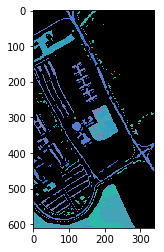

In [9]:
# create mask with same dimensions as image
mask = np.zeros_like(img_clustered)

# copy your image_mask to all dimensions (i.e. colors) of your image
for i in range(3): 
    mask[:,:,i] = htruth_mask.copy()

# apply the mask to your image
masked_image = clustered*mask

plt.imshow(masked_image)
plt.show()

In [10]:
martinIndex(hgtruth_mask, masked_image)*1000

168.91951912158373

### FCM

Fuzzy C-Means clustering time to do: 54.05s


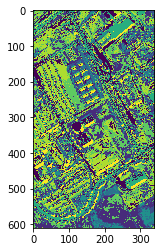

(610, 340)

In [18]:
import skfuzzy
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

#Turn into grayscale
img_gray = rgb2gray(reduced_data_3D)

# Reshape data
img_flat = img_gray.reshape((1, -1))

n_clusters = 9

t0 = time.time()
# Run algorithm
fzz = skfuzzy.cluster.cmeans(img_flat, c = n_clusters, m = 2, error=0.005, maxiter=1000)
t1 = time.time()

#Find clustering from fuzzy segmentation
img_clustered = np.argmax(fzz[1], axis=0).astype(float)
img_clustered.shape = img_gray.shape

plt.imshow(img_clustered)
title = 'Fuzzy C-Means clustering time to do: %.2fs' % (t1 - t0)
print(title)
plt.show()
img_clustered.shape

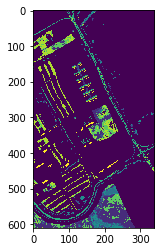

array([[2., 1., 7., ..., 1., 1., 6.],
       [1., 0., 5., ..., 2., 1., 6.],
       [6., 5., 8., ..., 1., 1., 1.],
       ...,
       [7., 7., 7., ..., 6., 6., 6.],
       [7., 7., 7., ..., 6., 6., 6.],
       [7., 7., 7., ..., 6., 6., 6.]])

In [20]:
# DIfferently from previous methods, this section that is commented does not work because the matrix is 
# (640,300) and not (640,300,3)


# # create mask with same dimensions as image
# mask = np.zeros_like(img_clustered)

# copy your image_mask to all dimensions (i.e. colors) of your image
# for i in range(3): 
#     mask[:,:,i] = htruth_mask.copy()


#So I applied the matrix directly and it work, but still not 3D

# apply the mask to your image
masked_image = img_clustered*htruth_mask

plt.imshow(masked_image)
plt.show()
masked_image
img_clustered

In [13]:
# THis does not work, issue described above


martinIndex(hgtruth_mask, masked_image)*1000
# masked_image.shape
# np.savetxt("foo.csv", masked_image, delimiter=",")

216.66301509407765

### Spectral

In [43]:
import time
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# img_r = rescale(reduced_data_3D,0.1,mode='reflect')

#Turn into grayscale
img_gray = rgb2gray(reduced_data_3D)

graph = image.img_to_graph(img_gray)#, mask=mask)

beta = 5
eps = 1e-6
graph.data = np.exp(-beta * graph.data / graph.data.std()) + eps

n_clusters = 9

t0 = time.time()
img_clustered = spectral_clustering(graph, n_clusters=n_clusters, assign_labels = 'discretize')
t1 = time.time()
img_clustered = img_clustered.reshape(img_gray.shape)


title = 'Spectral clustering time to do: %.2fs' % (t1 - t0)
print(title)
plt.imshow(img_clustered)
plt.show()
img_clustered

KeyboardInterrupt: 

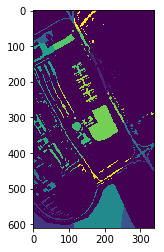

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0]], dtype=int64)

In [39]:
# mask = rescale(htruth_mask,0.1,mode='reflect')

# apply the mask to your image
masked_image = img_clustered*htruth_mask

plt.imshow(masked_image)
plt.show()

In [40]:
martinIndex(hgtruth_mask, masked_image)*1000

178.74010725579274

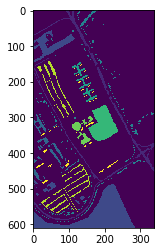

In [44]:
hgtruth_mask
plt.imshow(hgtruth_mask)
plt.show()

### GMM

In [ ]:
from sklearn import mixture

n_clusters = 9

gmm = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')

t0 = time.time()
# Run the algorithm
img_gmm = gmm.fit(img_data)
img_clustered = img_data[gmm.predict(img_data)].astype(float)
t1 = time.time()

# Reshape the data
img_clustered.shape = reduced_data_3D.shape

# Plot the data
plt.imshow(img_clustered)
title = 'Gaussian Mixture Model clustering time to do: %.2fs' % (t1 - t0)
print(title)
plt.show()

In [ ]:
# create mask with same dimensions as image
mask = np.zeros_like(img_clustered)

# copy your image_mask to all dimensions (i.e. colors) of your image
for i in range(3): 
    mask[:,:,i] = htruth_mask.copy()
    
# apply the mask to your image
masked_image = img_clustered*mask

plt.imshow(masked_image)
plt.show()

In [ ]:
martinIndex(hgtruth_mask, masked_image)*1000